In [1]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "duckdb",
#     "matplotlib",
#     "numpy",
#     "pandas",
#     "polars-lts-cpu",
#     "pyarrow",
#     "scipy",
#     "seaborn",
# ]
#
# [tool.uv]
# exclude-newer = "2025-05-21T15:04:48.473397636+02:00"
# ///

# Inspect processed data

## Setup

In [2]:
import duckdb
import numpy as np
import pandas as pd
import polars as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
import seaborn as sns
from pathlib import Path
from datetime import datetime

In [3]:
# fig_width = 4.78
fig_width = 8
fig_height = fig_width * 0.618

In [4]:
# mpl.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Times New Roman", "TeX Gyre Termes", "Times"],
#     "font.size": 10,
#     "axes.labelsize": 10,
#     "legend.fontsize": 8,
#     "xtick.labelsize": 8,
#     "ytick.labelsize": 8,
#     "figure.figsize": (fig_width, fig_height),
#     "text.latex.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}",
# })

In [5]:
data_path = Path("../data/processed/v1.1")
date_filter = "year=*/month=*/day=*"

In [6]:
con = duckdb.connect(database=":memory:")

In [7]:
con.sql(f"""
    CREATE OR REPLACE VIEW annotations AS
    SELECT *
    FROM read_parquet(
        '{data_path}/{date_filter}/annotations.parquet',
        hive_partitioning='true')
""")

In [8]:
con.sql("FROM annotations LIMIT 5").df()

,anomaly_id,label,start,stop,src_ip,src_port,dst_ip,dst_port,proto,taxonomy,heuristic,detectors,distance,day,month,year
0,0,anomalous,<NA>,<NA>,84.148.42.237,<NA>,149.34.212.145,80,None,salphfl,0.10870,5,NaN,01,01,2007
1,1,anomalous,<NA>,<NA>,206.30.238.144,<NA>,215.37.127.61,80,None,heavy_hitter,0.54140,10,NaN,01,01,2007
2,2,anomalous,<NA>,<NA>,None,<NA>,149.34.212.198,80,None,mptmp,0.20901,6,NaN,01,01,2007
3,2,anomalous,<NA>,<NA>,None,<NA>,214.138.176.172,80,None,mptmp,0.20901,6,NaN,01,01,2007
4,3,anomalous,<NA>,<NA>,164.89.55.232,80,None,<NA>,None,ptmpHTTP,0.34674,6,NaN,01,01,2007


In [9]:
con.sql(f"""
    CREATE OR REPLACE VIEW packets AS
    SELECT *
    FROM read_parquet(
        '{data_path}/{date_filter}/packet_metadata.parquet',
        hive_partitioning='true')
""")

In [10]:
con.sql("FROM packets LIMIT 5").df()

,timestamp,src_ip,dst_ip,src_port,dst_port,proto,packet_idx,file_pos,packet_size,anomaly_id,label,day,month,year
0,1.293858e+09,159.46.232.166,207.157.16.84,43541,48992,TCP,0,106,66,23,anomalous,01,01,2011
1,1.293858e+09,159.46.232.166,207.157.16.84,43541,48992,TCP,1,188,66,23,anomalous,01,01,2011
2,1.293858e+09,159.46.232.166,207.157.16.84,43541,48992,TCP,2,270,66,23,anomalous,01,01,2011
3,1.293858e+09,159.46.232.166,207.157.16.84,43541,48992,TCP,3,352,66,23,anomalous,01,01,2011
4,1.293858e+09,209.114.168.97,55.233.199.20,23269,28161,UDP,4,410,42,<NA>,benign,01,01,2011


In [11]:
con.sql(f"""
    CREATE OR REPLACE VIEW flows AS
    SELECT *
    FROM read_parquet(
        '{data_path}/{date_filter}/cicflowmeter_flows.parquet',
        hive_partitioning='true')
""")

In [12]:
con.sql("FROM flows LIMIT 5").df()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Label,filename,Anomaly ID,Taxonomy,Heuristic,Detectors,Distance,day,month,year
0,215.32.209.61-168.203.147.27-80-1521-6,215.32.209.61,80,168.203.147.27,1521,6,2011-01-01 05:00:00,119941565,11527,0,...,notice,data/cicflowmeter/v1.1/year=2011/month=01/day=...,144,mptplaHTTP,503.0,2,-0.531814,01,01,2011
1,209.114.165.130-146.70.21.154-0-0-0,209.114.165.130,0,146.70.21.154,0,0,2011-01-01 05:00:00,118651653,50,3,...,notice,data/cicflowmeter/v1.1/year=2011/month=01/day=...,144,mptplaHTTP,503.0,2,-0.531814,01,01,2011
2,209.114.1.69-35.49.246.12-58584-3544-17,209.114.1.69,58584,35.49.246.12,3544,17,2011-01-01 05:00:00,113082093,29,0,...,notice,data/cicflowmeter/v1.1/year=2011/month=01/day=...,144,mptplaHTTP,503.0,2,-0.531814,01,01,2011
3,209.114.1.69-40.162.238.134-58584-54384-17,209.114.1.69,58584,40.162.238.134,54384,17,2011-01-01 05:00:00,54578720,2,0,...,notice,data/cicflowmeter/v1.1/year=2011/month=01/day=...,144,mptplaHTTP,503.0,2,-0.531814,01,01,2011
4,209.114.1.69-36.170.121.167-58584-60801-17,209.114.1.69,58584,36.170.121.167,60801,17,2011-01-01 05:00:00,113080709,8,0,...,notice,data/cicflowmeter/v1.1/year=2011/month=01/day=...,144,mptplaHTTP,503.0,2,-0.531814,01,01,2011


In [13]:
label_colors = {
    "anomalous": "#d62728",  # red (danger)
    "benign":    "#2ca02c",  # green (safe)
    "notice":    "#1f77b4",  # blue (informational)
    "suspicious": "#ff7f0e", # orange (warning)
}

def get_label_colors(columns):
    return [label_colors.get(col, "#333333") for col in columns]

## Date coverage

In [14]:
date_coverage_flows = con.sql("""
    SELECT MAKE_DATE(
        CAST(year AS BIGINT),
        CAST(month AS BIGINT),
        CAST(day AS BIGINT)) AS date,
        COUNT(*) AS count
    FROM flows
    GROUP BY date
    ORDER BY date
""").df()
date_coverage_flows.head()

,date,count
0,2011-01-01,1342825
1,2011-01-02,1308489
2,2011-01-03,1780579
3,2011-01-04,1755863
4,2011-01-05,1900605


In [15]:
date_coverage_annotations = con.sql("""
    SELECT MAKE_DATE(
        CAST(year AS BIGINT),
        CAST(month AS BIGINT),
        CAST(day AS BIGINT)) AS date,
        COUNT(*) AS count
    FROM annotations
    GROUP BY date
    ORDER BY date
""").df()
date_coverage_annotations.head()

,date,count
0,2007-01-01,275
1,2007-01-02,228
2,2007-01-03,386
3,2007-01-04,281
4,2007-01-05,249


In [16]:
start_date = date_coverage_annotations['date'].min()
end_date = date_coverage_annotations['date'].max()
date_range = pd.date_range(start_date, end_date, freq='D')

num_years = (end_date.year - start_date.year) + 1

In [17]:
coverage_grid_flows = np.zeros((num_years, 366), dtype=int)

for idx, row in date_coverage_flows.iterrows():
    year_idx = row['date'].year - start_date.year
    day_of_year = row['date'].dayofyear - 1
    coverage_grid_flows[year_idx, day_of_year] = row['count']

In [18]:
coverage_grid_annotations = np.zeros((num_years, 366), dtype=int)

for idx, row in date_coverage_annotations.iterrows():
    year_idx = row['date'].year - start_date.year
    day_of_year = row['date'].dayofyear - 1
    coverage_grid_annotations[year_idx, day_of_year] = row['count']

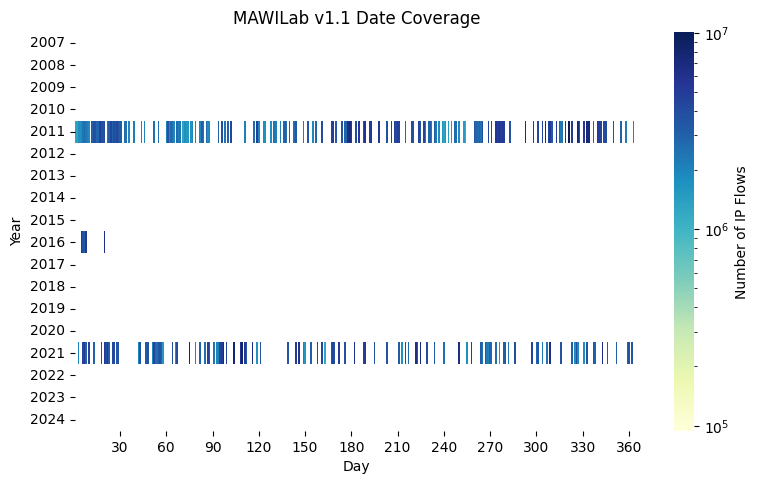

In [19]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
sns.heatmap(
    coverage_grid_flows,
    cmap="YlGnBu",
    norm=LogNorm(),
    cbar_kws={
        'label': 'Number of IP Flows',
        'format': ticker.LogFormatterSciNotation(base=10)
    })

# Customize tick labels
ax.set_yticks(np.arange(0.5, num_years))
ax.set_yticklabels(np.arange(start_date.year, end_date.year + 1), rotation=0)
ax.set_xticks(np.arange(29, 365, 30) + 0.5)
ax.set_xticklabels([f'{i+1}' for i in range(29, 365, 30)], rotation=0)

plt.title("MAWILab v1.1 Date Coverage")
plt.xlabel("Day")
plt.ylabel("Year")

plt.tight_layout()
plt.show()

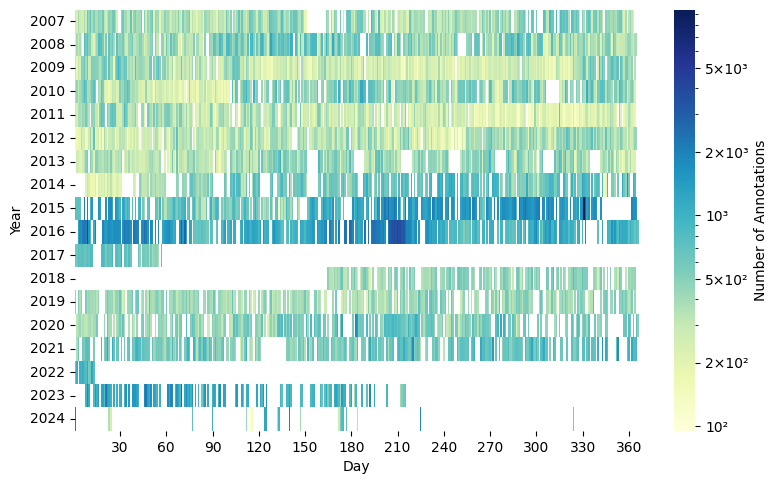

In [20]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
heatmap = sns.heatmap(
    coverage_grid_annotations,
    cmap="YlGnBu",
    norm=LogNorm(),
    cbar_kws={
        'label': 'Number of Annotations',
        'format': ticker.LogFormatterSciNotation(base=10)
    })

# Set custom ticks on the colorbar after creation
cbar = heatmap.collections[0].colorbar
cbar.set_ticks([100, 200, 500, 1000, 2000, 5000])
cbar.set_ticklabels(['10²', '2×10²', '5×10²', '10³', '2×10³', '5×10³'])

# Customize tick labels
ax.set_yticks(np.arange(0.5, num_years))
ax.set_yticklabels(np.arange(start_date.year, end_date.year + 1), rotation=0)
ax.set_xticks(np.arange(29, 365, 30) + 0.5)
ax.set_xticklabels([f'{i+1}' for i in range(29, 365, 30)], rotation=0)

#plt.title("MAWILab v1.1 Date Coverage")
plt.xlabel("Day")
plt.ylabel("Year")

plt.tight_layout()
#plt.savefig("../figures/mawilabv1.1_filters_per_day.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

## Labels

In [21]:
unique_labels = con.sql("""
    SELECT DISTINCT label
    FROM packets
""").df()
unique_labels

,label
0,suspicious
1,notice
2,benign
3,anomalous


In [22]:
packet_label_distribution = con.sql("""
    SELECT
        MAKE_DATE(
            CAST(year AS BIGINT),
            CAST(month AS BIGINT),
            CAST(day AS BIGINT)) AS date,
        Label as label,
        COUNT(label) as count
    FROM packets
    GROUP BY date, label
    ORDER BY date
""").df().pivot(index='date', columns='label', values='count').fillna(0)
packet_label_distribution.head()

label,anomalous,benign,notice,suspicious
date,,,,
2011-01-01,9183532.0,9943871.0,806720.0,2928949.0
2011-01-02,9889419.0,9471985.0,0.0,2253588.0
2011-01-03,14553122.0,10814838.0,1115154.0,2833097.0
2011-01-04,10941956.0,16705759.0,1984166.0,2285170.0
2011-01-05,10376675.0,14686638.0,0.0,3918989.0


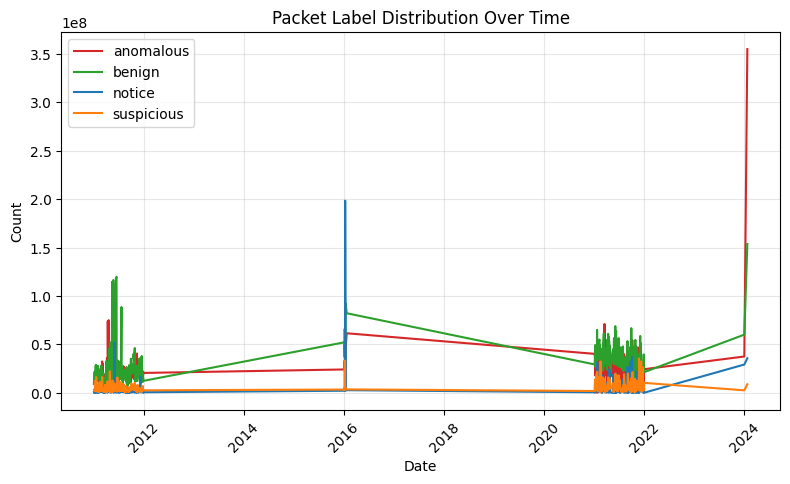

In [ ]:
plt.figure(figsize=(fig_width, fig_height))
for column in packet_label_distribution.columns:
    sns.lineplot(
        x=packet_label_distribution.index,
        y=packet_label_distribution[column],
        label=column,
        color=label_colors.get(column)
    )

plt.title("Packet Label Distribution Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

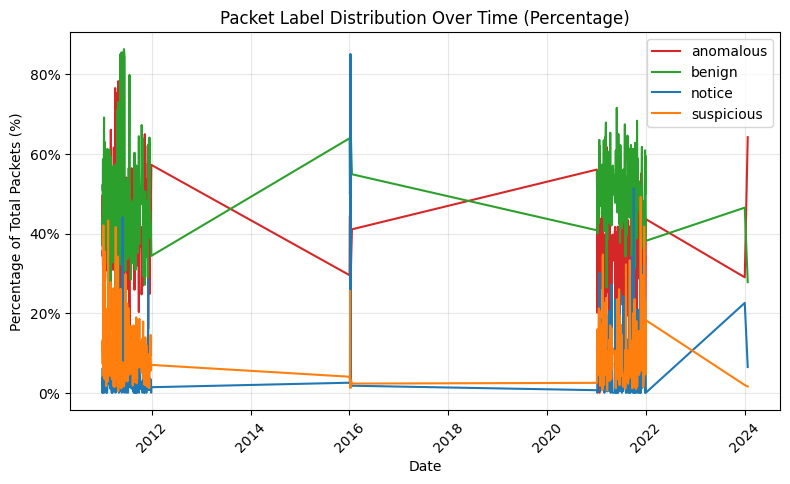

In [ ]:
packet_label_distribution_relative = packet_label_distribution.div(
    packet_label_distribution.sum(axis=1), axis=0) * 100

plt.figure(figsize=(fig_width, fig_height))
for column in packet_label_distribution_relative.columns:
    sns.lineplot(
        x=packet_label_distribution_relative.index,
        y=packet_label_distribution_relative[column],
        label=column,
        color=label_colors.get(column)
    )

plt.title("Packet Label Distribution Over Time (Percentage)")
plt.xlabel("Date")
plt.ylabel("Percentage of Total Packets (%)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.show()

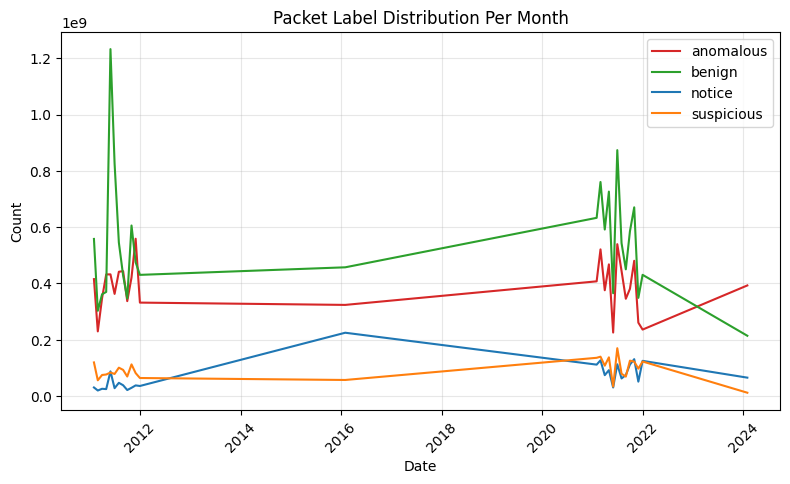

In [ ]:
packet_label_distribution_per_month = packet_label_distribution.resample('ME').sum()
packet_label_distribution_per_month = packet_label_distribution_per_month[packet_label_distribution_per_month.sum(axis=1) > 0]

plt.figure(figsize=(fig_width, fig_height))
for column in packet_label_distribution_per_month.columns:
    sns.lineplot(
        x=packet_label_distribution_per_month.index,
        y=packet_label_distribution_per_month[column],
        label=column,
        color=label_colors.get(column)
    )

plt.title("Packet Label Distribution Per Month")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

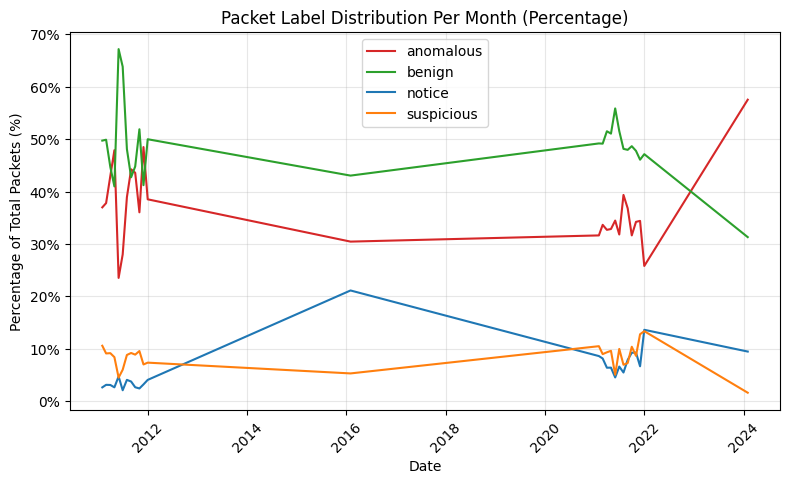

In [ ]:
packet_label_distribution_per_month_relative = packet_label_distribution_per_month.div(
    packet_label_distribution_per_month.sum(axis=1), axis=0) * 100

# Plot the relative percentages over time using seaborn
plt.figure(figsize=(fig_width, fig_height))
for column in packet_label_distribution_per_month_relative.columns:
    sns.lineplot(
        x=packet_label_distribution_per_month_relative.index,
        y=packet_label_distribution_per_month_relative[column],
        label=column,
        color=label_colors.get(column)
    )

plt.title("Packet Label Distribution Per Month (Percentage)")
plt.xlabel("Date")
plt.ylabel("Percentage of Total Packets (%)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.show()

In [27]:
packet_label_distribution_per_year = packet_label_distribution.resample('YE').sum()
packet_label_distribution_per_year = packet_label_distribution_per_year[packet_label_distribution_per_year.sum(axis=1) > 0]
packet_label_distribution_per_year.index = packet_label_distribution_per_year.index.year
packet_label_distribution_per_year

label,anomalous,benign,notice,suspicious
date,,,,
2011,4.750413e+09,6.480123e+09,4.186156e+08,1.003285e+09
2016,3.234046e+08,4.570627e+08,2.244763e+08,5.651046e+07
2021,4.681623e+09,6.976963e+09,1.097708e+09,1.334714e+09
2024,3.925978e+08,2.137277e+08,6.477693e+07,1.120975e+07


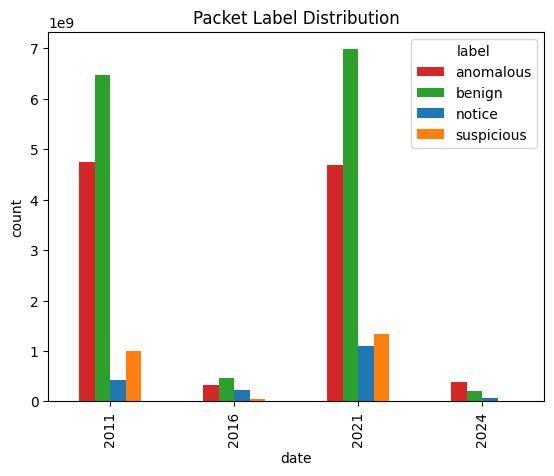

In [28]:
packet_label_distribution_per_year.plot.bar(
    title="Packet Label Distribution",
    color=get_label_colors(packet_label_distribution_per_year.columns))
plt.gca().set_ylabel("count")
plt.show()

In [29]:
packet_label_distribution_per_year_relative = packet_label_distribution_per_year.div(
    packet_label_distribution_per_year.sum(axis=1), axis=0) * 100
packet_label_distribution_per_year_relative

label,anomalous,benign,notice,suspicious
date,,,,
2011,37.545439,51.216406,3.308577,7.929578
2016,30.468071,43.060054,21.148003,5.323872
2021,33.224189,49.513585,7.790130,9.472096
2024,57.539317,31.324038,9.493739,1.642907


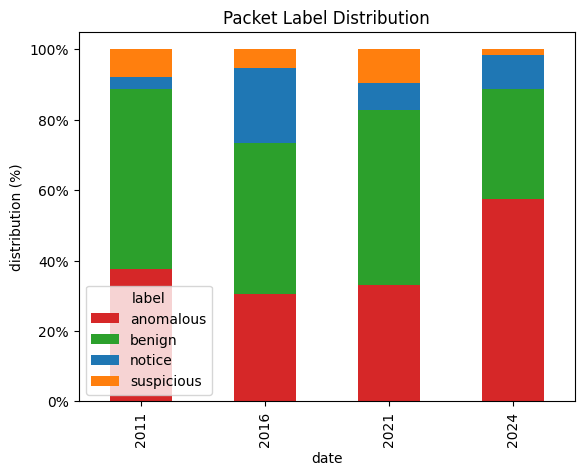

In [30]:
packet_label_distribution_per_year_relative.plot.bar(
    stacked=True, title="Packet Label Distribution",
    color=get_label_colors(packet_label_distribution_per_year.columns))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().set_ylabel("distribution (%)")
plt.show()

In [31]:
flow_label_distribution = con.sql("""
    SELECT year, Label as label, COUNT(label) as count
    FROM flows
    GROUP BY year, label
    ORDER BY year
""").df().pivot(index="year", columns="label", values="count").fillna(0)
flow_label_distribution

label,anomalous,benign,notice,suspicious
year,,,,
2011,258218497,252696881,22753587,57264807
2016,12199329,8667968,1204218,1813010
2021,222185696,122627279,35550528,52472599
2024,19716,58360,14159,1958


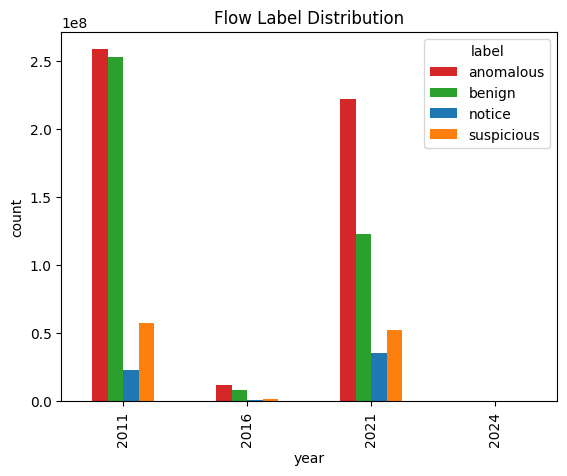

In [32]:
flow_label_distribution.plot.bar(
    title="Flow Label Distribution",
    color=get_label_colors(packet_label_distribution.columns))
plt.gca().set_ylabel("count")
plt.show()

In [33]:
flow_label_distribution_relative = flow_label_distribution.div(
    flow_label_distribution.sum(axis=1), axis=0) * 100
flow_label_distribution_relative

label,anomalous,benign,notice,suspicious
year,,,,
2011,43.696690,42.762301,3.850446,9.690563
2016,51.076289,36.291147,5.041834,7.590731
2021,51.332524,28.331112,8.213393,12.122972
2024,20.931492,61.957895,15.031903,2.078711


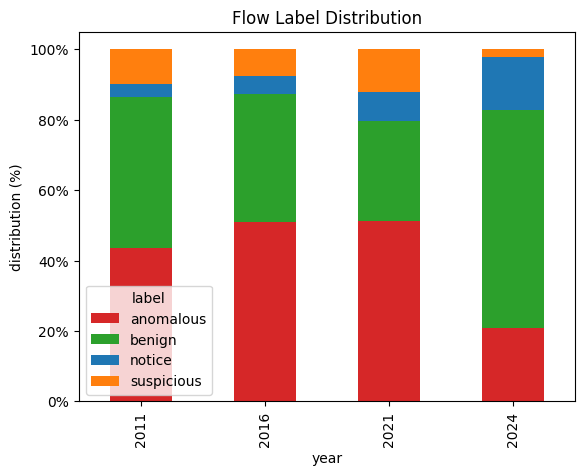

In [34]:
flow_label_distribution_relative.plot.bar(
    stacked=True, title="Flow Label Distribution",
    color=get_label_colors(packet_label_distribution.columns))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().set_ylabel("distribution (%)")
plt.show()

## Anomaly count

In [35]:
anomaly_count = con.sql("""
    SELECT
        label,
        MAKE_DATE(
            CAST(year as BIGINT),
            CAST(month as BIGINT),
            CAST(day as BIGINT)
        ) AS date,
        COUNT(DISTINCT(anomaly_id, label)) as count
    FROM annotations
    GROUP BY date, label
    ORDER BY date
""").df()
anomaly_count.head()

,label,date,count
0,notice,2007-01-01,105
1,anomalous,2007-01-01,38
2,suspicious,2007-01-01,68
3,notice,2007-01-02,92
4,anomalous,2007-01-02,38


In [36]:
anomaly_count.dtypes

label            object
date     datetime64[us]
count             int64
dtype: object

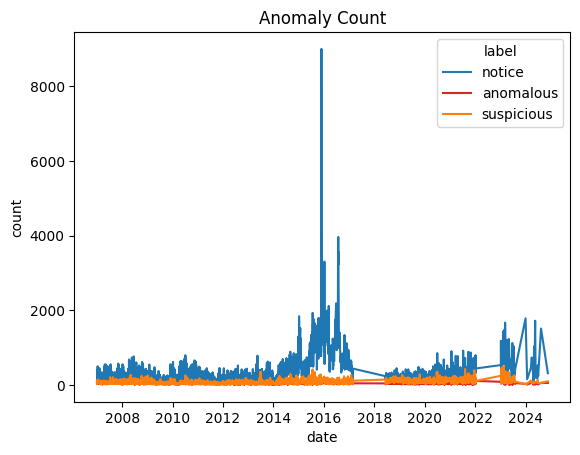

In [37]:
sns.lineplot(
    data=anomaly_count,
    x="date",
    y="count",
    hue="label",
    palette=label_colors)
plt.title("Anomaly Count")
plt.show()

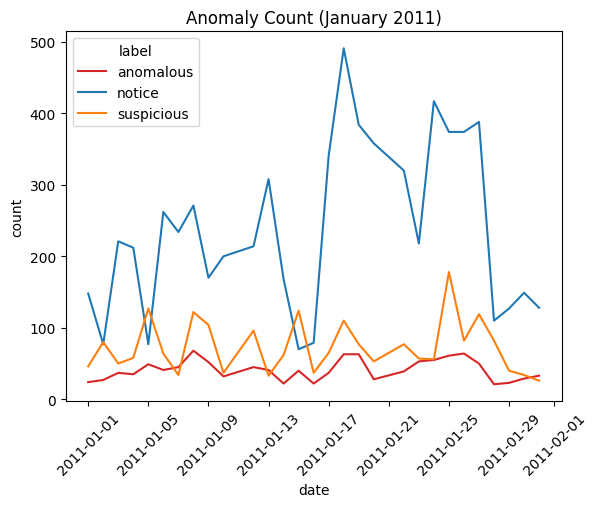

In [38]:
sns.lineplot(
    data=anomaly_count[anomaly_count["date"].dt.to_period("M") == "2011-01"],
    x="date",
    y="count",
    hue="label",
    palette=label_colors)
plt.title("Anomaly Count (January 2011)")
plt.xticks(rotation=45)
plt.show()

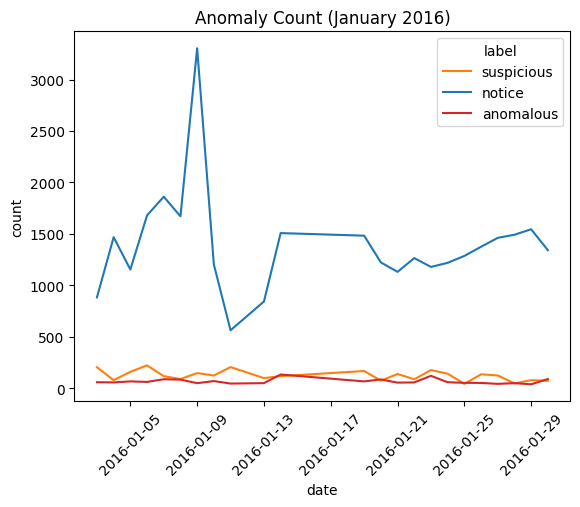

In [39]:
sns.lineplot(
    data=anomaly_count[anomaly_count["date"].dt.to_period("M") == "2016-01"],
    x="date",
    y="count",
    hue="label",
    palette=label_colors)
plt.title("Anomaly Count (January 2016)")
plt.xticks(rotation=45)
plt.show()

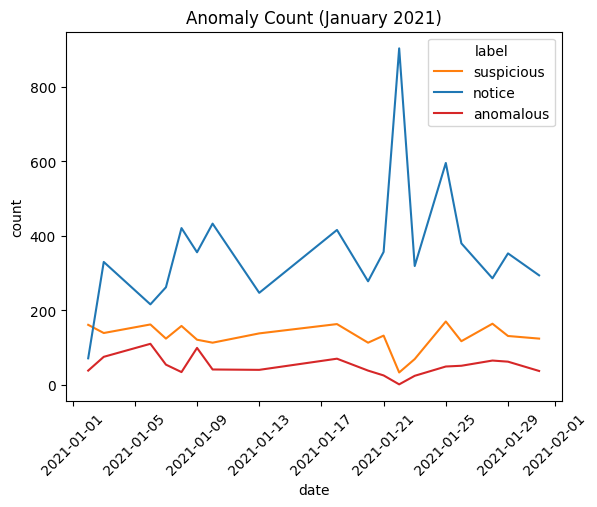

In [40]:
sns.lineplot(
    data=anomaly_count[anomaly_count["date"].dt.to_period("M") == "2021-01"],
    x="date",
    y="count",
    hue="label",
    palette=label_colors)
plt.title("Anomaly Count (January 2021)")
plt.xticks(rotation=45)
plt.show()

## Features

In [41]:
unique_taxonomies = con.sql("""
    SELECT DISTINCT taxonomy
    FROM annotations
""").df()
print(f"Number of unique taxonomies: {len(unique_taxonomies)}")
unique_taxonomies["taxonomy"].sort_values().values

Number of unique taxonomies: 76


array(['DDoSIC', 'DDoSRSTrp', 'DDoSSYN', 'DDoSSYNACKrp', 'DDoSUDP',
       'alphfl', 'alphflHTTP', 'dntscSYN', 'empty', 'heavy_hitter',
       'hostout', 'icmp_error', 'ipv46tun', 'ipv4gretun', 'malphfl',
       'mptmp', 'mptp', 'mptpHTTP', 'mptpla', 'mptplaHTTP', 'netout',
       'ntscACK', 'ntscACKt', 'ntscICec', 'ntscICecrqICdurmterp',
       'ntscICecrqICdurp', 'ntscICecrqICecrprp',
       'ntscICecrqICecrqdurmterp', 'ntscICecrqICterp', 'ntscSYN',
       'ntscSYN139445', 'ntscSYNSAbado', 'ntscSYNt', 'ntscSYNt139445',
       'ntscSYNtSAbado', 'ntscTCPICdurp', 'ntscTCPICrp', 'ntscTCPICterp',
       'ntscTCPRSTACKrp', 'ntscTCPRSTrp', 'ntscTCPTCPICrp', 'ntscUDP',
       'ntscUDPDNS', 'ntscUDPICdurp', 'ntscUDPICrp', 'ntscUDPICterp',
       'ntscUDPOther', 'ntscUDPUDPICrp', 'ntscUDPUDPrp', 'out',
       'point_to_point', 'poscUDPICrp', 'poscaFIN', 'poscaFINRST',
       'poscaRST', 'poscaSYN', 'poscaUDP', 'ptmp', 'ptmpHTTP', 'ptmpla',
       'ptmplaHTTP', 'ptpDoSIC', 'ptpDoSSYN', 'ptpposc

In [42]:
heuristics = con.sql("""
    SELECT heuristic
    FROM annotations
""").df()
print(f"Number of NaN heuristics: {heuristics['heuristic'].isna().sum()}")
heuristics.describe()

Number of NaN heuristics: 0


,heuristic
count,2.466236e+06
mean,3.439458e+02
std,3.847214e+02
min,-1.658890e+00
25%,2.609175e-01
50%,2.000000e+01
75%,5.040000e+02
max,9.990000e+02


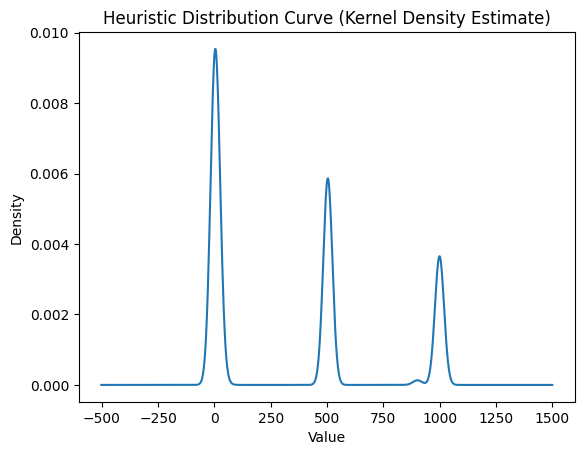

In [43]:
plt.figure()
heuristics['heuristic'].plot(kind='kde')
plt.title('Heuristic Distribution Curve (Kernel Density Estimate)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [44]:
distances = con.sql("""
    SELECT distance
    FROM annotations
""").df()
print(f"Number of NaN distances: {distances['distance'].isna().sum()}")
distances.dropna().describe()

Number of NaN distances: 783929


,distance
count,1.682307e+06
mean,-9.983766e-01
std,5.323481e-01
min,-4.810198e+00
25%,-1.211951e+00
50%,-8.629880e-01
75%,-6.376130e-01
max,-2.396750e-01


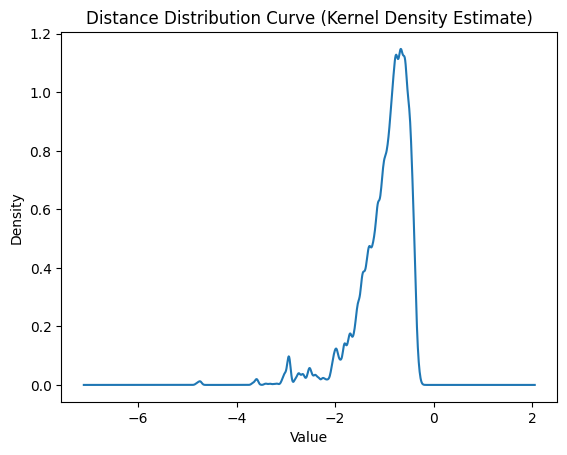

In [45]:
plt.figure()
distances['distance'].dropna().plot(kind='kde')
plt.title('Distance Distribution Curve (Kernel Density Estimate)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

## Approximate size of MAWILab v1.1

In [46]:
import subprocess
import re

du_result = subprocess.run(
    ["du", "-d3", "-m", "../data/raw/v1.1"],
    capture_output=True,
    text=True
)

In [47]:
pattern = r'(\d+)\t.*?/year=(\d{4})/month=(\d{2})/day=(\d{2})$'
day_sizes = []

for line in du_result.stdout.split("\n"):
    match = re.match(pattern, line)
    if match:
        size, year, month, day = match.groups()
        day_sizes.append({
            "size": int(size),
            "year": int(year),
            "month": int(month),
            "day": int(day)
        })
day_sizes_df = pd.DataFrame(day_sizes)
day_sizes_df['date'] = pd.to_datetime(
    day_sizes_df[['year', 'month', 'day']])
day_sizes_df = day_sizes_df.sort_values(by='date')
day_sizes_df.head()


,size,year,month,day,date
0,180,2007,1,1,2007-01-01
1,235,2007,1,2,2007-01-02
2,225,2007,1,3,2007-01-03
3,267,2007,1,4,2007-01-04
4,1,2007,1,5,2007-01-05


In [48]:
day_sizes_df.describe()

,size,year,month,day,date
count,4458.000000,4458.000000,4458.000000,4458.000000,4458
mean,217.154105,2013.786451,6.378869,15.958277,2014-04-10 20:13:53.378196736
min,1.000000,2007.000000,1.000000,1.000000,2007-01-01 00:00:00
25%,1.000000,2010.000000,3.000000,9.000000,2010-04-29 18:00:00
50%,1.000000,2013.000000,6.000000,16.000000,2013-09-15 12:00:00
75%,1.000000,2018.000000,9.000000,23.000000,2018-05-21 18:00:00
max,14365.000000,2024.000000,12.000000,31.000000,2024-11-19 00:00:00
std,718.743153,4.581197,3.420073,8.717672,NaN


In [49]:
# make all sizes below 10 MB NaN
day_sizes_df.loc[day_sizes_df['size'] < 10, 'size'] = np.nan

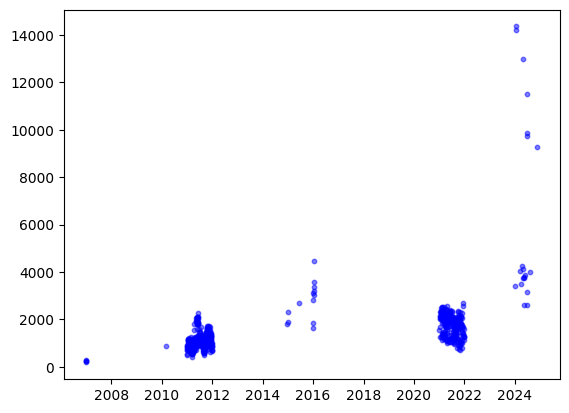

In [50]:
plt.scatter(
    day_sizes_df['date'],
    day_sizes_df['size'],
    s=10, alpha=0.5, color='blue'
)
plt.show()

In [51]:
# linearly interpolate the sizes
day_sizes_df['size'] = day_sizes_df['size'].interpolate(method='linear')

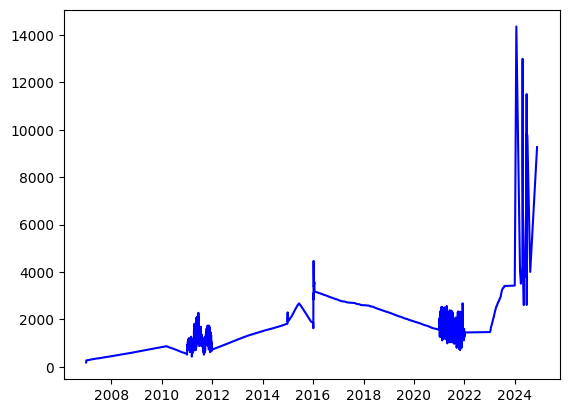

In [52]:
plt.plot(
    day_sizes_df['date'],
    day_sizes_df['size'],
    linestyle='-',
    color='blue'
)
plt.show()

In [53]:
f"Total dataset size is approximately {day_sizes_df['size'].sum() / 1024:,.2f} GB"

'Total dataset size is approximately 6,540.61 GB'